Homework #5. Exploratory Data Analysis)
Author: Kateryna Burovova
Total time spent on h/w (in minutes): 480

In [2]:
import pandas as pd
import fasttext
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tokenize_uk import tokenize_words
import re

### Initial data prep

In [18]:
DIALOGS_MERGED_DATA_PATH = "../data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data/merged_data/dialogs_users_all.csv"

In [19]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_22255/1251569782.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)


In [5]:
df_meta_dialogs = df_meta.groupby('dialog_id')['users'].apply(list)

In [6]:
df_dialog_info = (df_meta_dialogs
                  .to_frame()
                  .merge(df_meta[['dialog_id', 'name', 'type']], on = 'dialog_id', how='left'))

In [7]:
df_dialog_info = df_dialog_info.drop_duplicates(subset='dialog_id', keep='first')
df_full = df.merge(df_dialog_info, on = 'dialog_id', how='left')

In [7]:
df_full = df_full.rename(columns={
    'type_x':'message_type',
    'type_y':'dialog_type',
})

In [8]:
my_user_id = 'PeerUser(user_id=50039420)'

In [9]:
df_full['recipient_type'] = np.where(df_full["from_id"] == my_user_id, 'sent', 'received')

### Which languages are used in chats? What's the message count for top languages?

In [10]:
class LanguageIdentification:

    def __init__(self):
        pretrained_lang_model = "/Users/katerynaburovova/PycharmProjects/comp_soc_sci_projects/fasttext/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text, label_only=True):
        predictions = self.model.predict(text, k=1)
        if label_only:
            return predictions[0][0][-2:]
        return predictions

In [11]:
lang_identifier = LanguageIdentification()

In [12]:
# we need to remove \n because lang_identifier will process 1 line at a time
df_full['message'] = df_full['message'].apply(lambda x: str(x).replace('\n', ' '))

In [13]:
df_full['lang'] = df_full['message'].apply(lambda x: lang_identifier.predict_lang(x))

In [14]:
df_full['lang'].value_counts()

ru    1060701
uk     237772
ht     197725
en      53643
bg      32298
       ...   
mr          1
ie          1
mg          1
st          1
wa          1
Name: lang, Length: 141, dtype: int64

Doesn't look right, must be emoji, pics or voice artifacts. What's the amount of non-textual messages taken into account?

In [15]:
df_full['lang'][df_full['message_type']!='text']='not_applicable'

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_45947/3355220618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['lang'][df_full['message_type']!='text']='not_applicable'


### What's the distribution of languages in text messages?

In [16]:
df_full['lang'].value_counts()

ru                1012415
not_applicable     327047
uk                 175745
ht                  30917
bg                  29392
                   ...   
rm                      1
jv                      1
bk                      1
mo                      1
wa                      1
Name: lang, Length: 142, dtype: int64

Let's look at two main languages only.

In [17]:
languages_to_compare = ['uk','ru']

In [18]:
ua_ru=(df_full.lang
 .where(df_full.lang.isin(languages_to_compare), other = 'Other')
 .value_counts()
 .reset_index(name="count")
 .set_index('index'))


<AxesSubplot:title={'center':'Distribution of language usage - ru vs uk vs others'}, xlabel='index'>

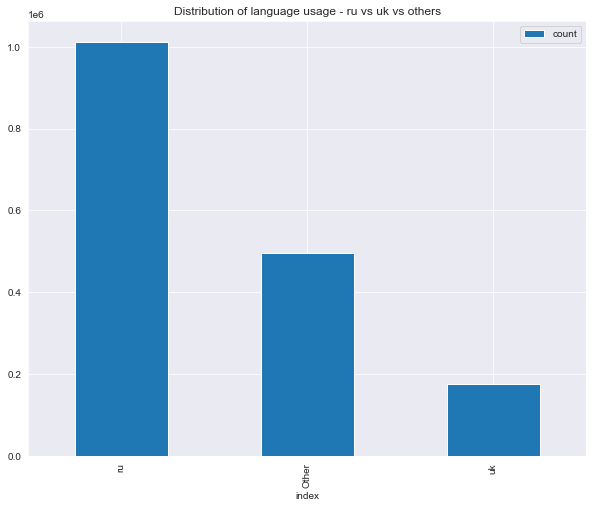

In [19]:
ua_ru.plot.bar(title = "Distribution of language usage - ru vs uk vs others", figsize=(10, 8))

### How did ru and ukr message qqty change over time?

In [20]:
df_full['date'] = pd.to_datetime(df_full['date'])

In [21]:
ua_ru_in_time = (df_full[['lang', 'date']]
                 .assign(final_languages = lambda df_: df_.lang.where(df_.lang.isin(languages_to_compare), other = 'Other'))
                 .groupby(['final_languages', 'date'])['final_languages']
                 .count()
                 .reset_index(name="count")
                 .sort_values(by='date')
                 .set_index(['date']))

In [22]:
summary = (ua_ru_in_time[['count', 'final_languages']]
           .groupby('final_languages')['count']
           .resample('M')
           .sum()
           .reset_index(name="count"))

Text(0.5, 0.98, 'Change in qtty of messages in main languages')

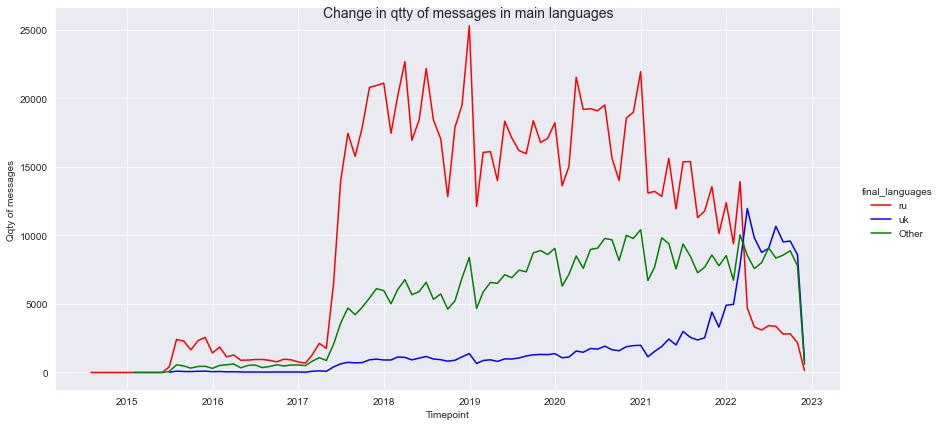

In [23]:
g = sns.relplot(
 kind='line',
 data=summary,
 x='date', y='count',
 palette = ['red', 'blue', 'green'],
 hue_order = ['ru', 'uk', 'Other'],
 hue='final_languages',
 height=6,
 aspect = 2
)
(g
    .set_axis_labels("Timepoint", "Qqty of messages")
    .set_titles("Region: {col_name} cortex")
    .tight_layout(w_pad=0)
    .fig.suptitle("Change in qtty of messages in main languages", fontsize=14))

### How did the ru / ua / other lang distribution change over time? !FOR HW6!

In [24]:
summary2 = (summary
            .merge(summary
                   .groupby('date')['count']
                   .apply(sum)
                   .reset_index(name="total_count"), on = 'date', how='left')
            .assign(percentage = lambda df_ : df_['count']/df_['total_count'])
            .fillna(0))

In [25]:
summary2

,final_languages,date,count,total_count,percentage
0,Other,2015-01-31 00:00:00+00:00,1,1,1.000000
1,Other,2015-02-28 00:00:00+00:00,0,0,0.000000
2,Other,2015-03-31 00:00:00+00:00,0,0,0.000000
3,Other,2015-04-30 00:00:00+00:00,0,0,0.000000
4,Other,2015-05-31 00:00:00+00:00,0,0,0.000000
...,...,...,...,...,...
281,uk,2022-07-31 00:00:00+00:00,10657,22363,0.476546
282,uk,2022-08-31 00:00:00+00:00,9519,20867,0.456175
283,uk,2022-09-30 00:00:00+00:00,9583,21288,0.450160
284,uk,2022-10-31 00:00:00+00:00,8589,18537,0.463344


Text(0.5, 0.98, 'Change in distribution of messages in main languages')

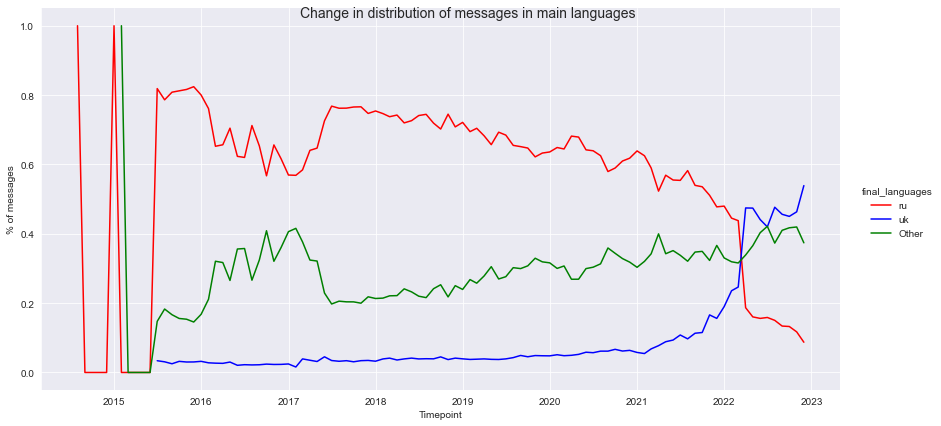

In [26]:
g = sns.relplot(
 kind='line',
 data=summary2,
 x='date', y='percentage',
 palette = ['red', 'blue', 'green'],
 hue_order = ['ru', 'uk', 'Other'],
 hue='final_languages',
 height=6,
 aspect = 2
)
(g
    .set_axis_labels("Timepoint", "% of messages")
    .tight_layout(w_pad=0)
    .fig.suptitle("Change in distribution of messages in main languages", fontsize=14))

We see now how dramatic the shift in languages usage really was.

### What are the most popular words that I use on average? !FOR HW6!

For further improvement I'll use lemmas instead of tokens.

In [27]:
import stanza

In [28]:
stanza.download('uk')

2022-12-07 12:47:04 INFO: Downloading default packages for language: uk (Ukrainian) ...
2022-12-07 12:47:05 INFO: File exists: /Users/katerynaburovova/stanza_resources/uk/default.zip
2022-12-07 12:47:06 INFO: Finished downloading models and saved to /Users/katerynaburovova/stanza_resources.


In [29]:
nlp_uk = stanza.Pipeline('uk')

2022-12-07 12:47:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-12-07 12:47:07 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package |
-----------------------
| tokenize  | iu      |
| mwt       | iu      |
| pos       | iu      |
| lemma     | iu      |
| depparse  | iu      |
| ner       | languk  |

2022-12-07 12:47:07 INFO: Use device: cpu
2022-12-07 12:47:07 INFO: Loading: tokenize
2022-12-07 12:47:07 INFO: Loading: mwt
2022-12-07 12:47:07 INFO: Loading: pos
2022-12-07 12:47:07 INFO: Loading: lemma
2022-12-07 12:47:07 INFO: Loading: depparse
2022-12-07 12:47:07 INFO: Loading: ner
2022-12-07 12:47:08 INFO: Done loading processors!


In [30]:
stanza.download('ru')

2022-12-07 12:47:08 INFO: Downloading default packages for language: ru (Russian) ...
2022-12-07 12:47:09 INFO: File exists: /Users/katerynaburovova/stanza_resources/ru/default.zip
2022-12-07 12:47:12 INFO: Finished downloading models and saved to /Users/katerynaburovova/stanza_resources.


In [31]:
nlp_ru = stanza.Pipeline('ru')

2022-12-07 12:47:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-12-07 12:47:14 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2022-12-07 12:47:14 INFO: Use device: cpu
2022-12-07 12:47:14 INFO: Loading: tokenize
2022-12-07 12:47:14 INFO: Loading: pos
2022-12-07 12:47:15 INFO: Loading: lemma
2022-12-07 12:47:15 INFO: Loading: depparse
2022-12-07 12:47:15 INFO: Loading: ner
2022-12-07 12:47:16 INFO: Done loading processors!


In [32]:
df_sent_messages = df_full[(df_full['recipient_type']=='sent')&((df_full['lang']=='uk')|(df_full['lang']=='ru'))][['message', 'lang']].reset_index(drop=True)

In [33]:
from string import punctuation

In [34]:
import nltk

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katerynaburovova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
stop_words_ru = nltk.corpus.stopwords.words('russian')

In [37]:
len(stop_words_ru)

151

In [38]:
stopwords_ua = pd.read_csv("/Users/katerynaburovova/PycharmProjects/comp_soc_sci_projects/HW4/telegram-dialogs-analysis-v2/stopwords_ua.txt", header=None, names=['stopwords'])
stop_words_ua = list(stopwords_ua.stopwords)

In [39]:
len(stop_words_ua)

1983

In [40]:
def get_word_tokens(lang, text):
    text = text.lower()
    if lang=='uk':
        doc = nlp_uk(text)
        word_tokens = [token.text for sent in doc.sentences for token in sent.tokens if token.text not in punctuation]
        result = [word for word in word_tokens if word not in stop_words_ua]
        return result
    else:
        doc = nlp_ru(text)
        word_tokens = [token.text for sent in doc.sentences for token in sent.tokens if token.text not in punctuation]
        result = [word for word in word_tokens if word not in stop_words_ru]
        return result

In [41]:
sent_messages_sample_list = (df_sent_messages
                             .sample(1000, random_state=42)
                             .apply(lambda x: get_word_tokens(x['lang'], x['message']), axis=1)
                             .tolist())

In [42]:
all_words = [item for sublist in sent_messages_sample_list for item in sublist]

<AxesSubplot:title={'center':'Distribution of words in my sent messages'}, xlabel='words'>

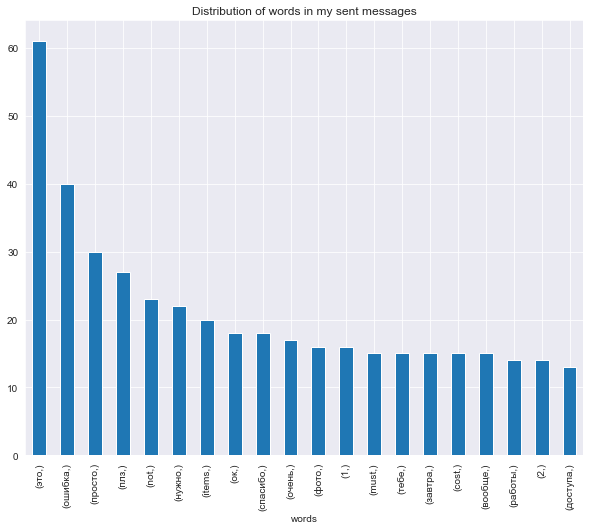

In [43]:
(pd.DataFrame(all_words, columns = ['words'])
              .value_counts()[:20]
              .plot
              .bar(title = "Distribution of words in my sent messages", figsize=(10, 8)))

### What are the most popular words that are being used in messages to me on average?

In [44]:
df_received_messages = df_full[(df_full['recipient_type']=='received')&((df_full['lang']=='uk')|(df_full['lang']=='ru'))][['message', 'lang']].reset_index(drop=True)

In [45]:
received_messages_sample_list = (df_received_messages
                             .sample(1000, random_state=42)
                             .apply(lambda x: get_word_tokens(x['lang'], x['message']), axis=1)
                             .tolist())

In [46]:
all_received_words = [item for sublist in received_messages_sample_list for item in sublist]


<AxesSubplot:title={'center':'Distribution of words in my received messages'}, xlabel='words'>

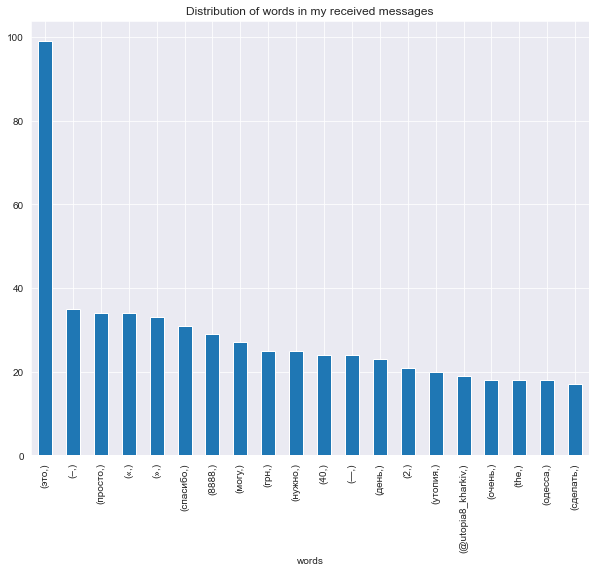

In [47]:
(pd.DataFrame(all_received_words, columns = ['words'])
              .value_counts()[:20]
              .plot
              .bar(title = "Distribution of words in my received messages", figsize=(10, 8)))

### What's the proportion of work- and non-work-related messages?

Here we consider all messages in work-related chats to be work-related.

In [48]:
def mark_work_chats(chat_name):
    work_indicators = ['u8', 'utopia8', "sdd", 'utopia', "slashdotdash", "slash dot dash", "utopia8.ua"]
    if len(set(str(chat_name).lower().split(' ')).intersection(set(work_indicators)))>0:
        return "work"
    else:
        return "play"

In [49]:
df_full['type_of_chat'] = df_full['name'].apply(lambda  x: mark_work_chats(x))

<AxesSubplot:title={'center':'Distribution of work/non-work-related messages'}, xlabel='type_of_chat'>

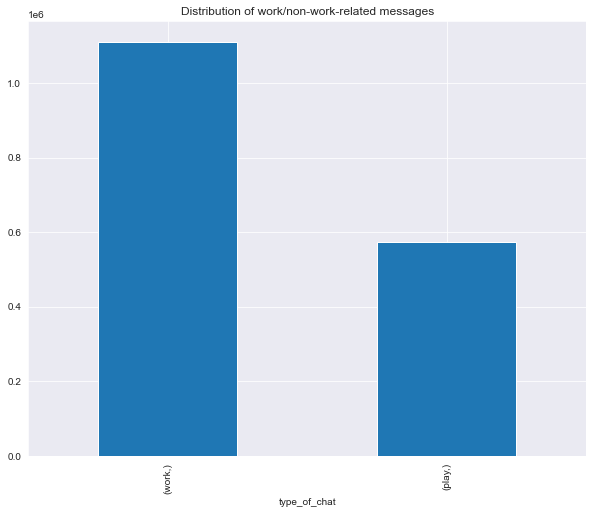

In [50]:
(df_full[['type_of_chat']]
 .value_counts()
 .plot
 .bar(title = "Distribution of work/non-work-related messages", figsize=(10, 8)))

### How does length of message (in meaningful words) to me and from me differ?

In [51]:
def Average(lst):
    return sum(lst) / len(lst)
average_received_words = Average([len(message) for message in received_messages_sample_list])

In [52]:
average_sent_words = Average([len(message) for message in sent_messages_sample_list])


In [53]:
average_received_words, average_sent_words

(9.121, 4.532)

<AxesSubplot:title={'center':'Comparison of length of sent and received messages'}, xlabel='type'>

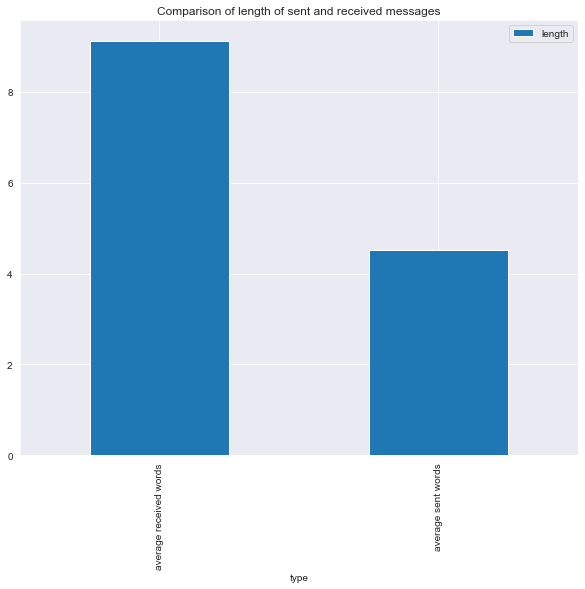

In [54]:
data = [['average received words', average_received_words], ['average sent words', average_sent_words]]
pd.DataFrame(data, columns=['type', 'length'])\
    .set_index('type')\
    .plot\
    .bar(title = "Comparison of length of sent and received messages", figsize=(10, 8))

### How did the length of work- and non-work-related messages change over time? !FOR HW6!

In [55]:
df_full['length'] = df_full['message'].apply(lambda x: len(x.split (' ')))

In [56]:
df_length = (df_full[['length', 'type_of_chat', 'date']]
 .groupby(['date', 'type_of_chat'])['length']
 .mean()
 .to_frame()
 .reset_index()
 .assign(date = lambda df_: pd.to_datetime(df_['date']))
 .set_index('date'))

In [57]:
summary_length = (df_length[['length', 'type_of_chat']]
                  .groupby('type_of_chat')['length']
                  .resample('M')
                  .mean()
                  .reset_index(name="average_length")
                  .fillna(0))

In [58]:
summary_length

,type_of_chat,date,average_length
0,play,2014-07-31 00:00:00+00:00,2.000000
1,play,2014-08-31 00:00:00+00:00,0.000000
2,play,2014-09-30 00:00:00+00:00,0.000000
3,play,2014-10-31 00:00:00+00:00,0.000000
4,play,2014-11-30 00:00:00+00:00,0.000000
...,...,...,...
169,work,2022-07-31 00:00:00+00:00,7.718932
170,work,2022-08-31 00:00:00+00:00,6.707218
171,work,2022-09-30 00:00:00+00:00,6.747572
172,work,2022-10-31 00:00:00+00:00,6.772517


Text(0.5, 0.98, 'Change in average length of work and non-work related messages ')

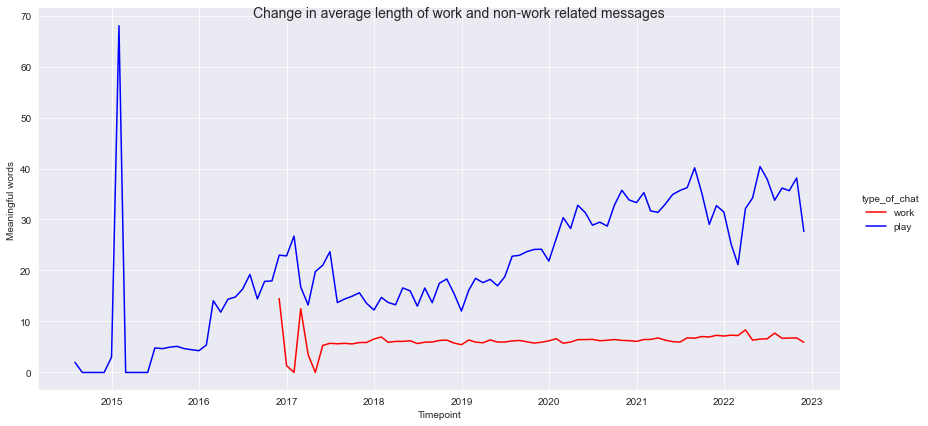

In [59]:
g = sns.relplot(
 kind='line',
 data=summary_length,
 x='date', y='average_length',
 palette = ['red', 'blue'],
 hue_order = ['work', 'play'],
 hue='type_of_chat',
 height=6,
 aspect = 2
)
(g
    .set_axis_labels("Timepoint", "Meaningful words")
    .tight_layout(w_pad=0)
    .fig.suptitle("Change in average length of work and non-work related messages ", fontsize=14))

### How did the length of messages (in words) sent to me and by me change over time? !FOR HW6!


In [60]:
df_length_add = (df_full[['length', 'recipient_type', 'date']]
 .groupby(['date', 'recipient_type'])['length']
 .mean()
 .to_frame()
 .reset_index()
 .assign(date = lambda df_: pd.to_datetime(df_['date']))
 .set_index('date'))

In [61]:
summary_length_add = (df_length_add[['length', 'recipient_type']]
                  .groupby('recipient_type')['length']
                  .resample('M')
                  .mean()
                  .reset_index(name="average_length")
                  .fillna(0))

Text(0.5, 0.98, 'Change in average length of work and non-work related messages ')

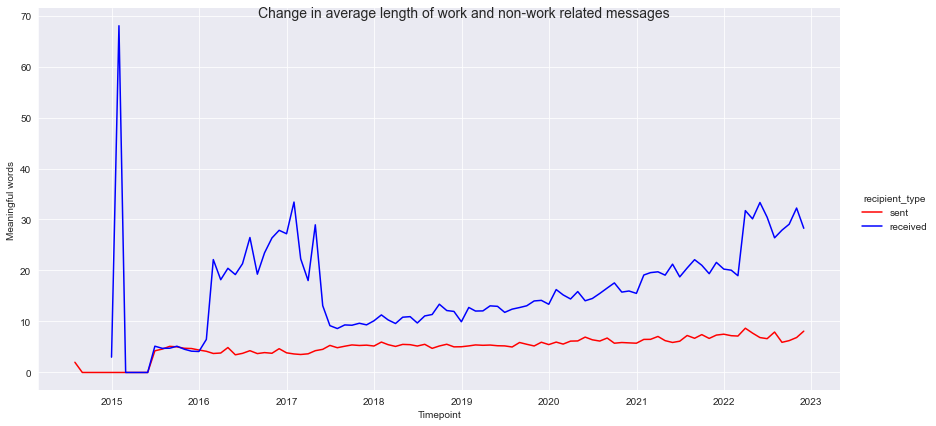

In [62]:
g = sns.relplot(
 kind='line',
 data=summary_length_add,
 x='date', y='average_length',
 palette = ['red', 'blue'],
 hue_order = ['sent', 'received'],
 hue='recipient_type',
 height=6,
 aspect = 2
)
(g
    .set_axis_labels("Timepoint", "Meaningful words")
    .tight_layout(w_pad=0)
    .fig.suptitle("Change in average length of work and non-work related messages ", fontsize=14))

### What are the 20 most popular emojis in general?

In [63]:
import emoji
import regex
import collections

In [65]:
def get_emoji_count(text):
    return collections.Counter([match["emoji"] for word in text for match in emoji.emoji_list(word)])

In [66]:
df_full['emoji_data'] = df_full['message'].apply(lambda x: get_emoji_count(x))

I'm taking 100 000 random subset (it speeds up calculation).

In [67]:
df_emojis = (df_full['emoji_data']
             .sample(100000, random_state=42)
             .apply(pd.Series, dtype = 'object')
             .fillna(0)
             )

In [68]:
cols = df_emojis.T.columns

In [69]:
df_emojis = df_emojis.T.reset_index()

In [70]:
df_emojis['count'] = df_emojis.iloc[:, 1:-1].sum(axis=1)

In [71]:
df_emojis = df_emojis.drop(columns=cols)

In [72]:
df_emojis = df_emojis.set_index('index')

In [73]:
df_emojis.sort_values(by='count', ascending=False)[:20]

,count
index,
▪,1238.0
❤,755.0
🏻,554.0
🔸,449.0
⚡,421.0
❗,405.0
☺,364.0
🙏,354.0
🙌,348.0


Emojis do not show as bucket label in plot, I hope this table is fine as an illustration.

### What are my favourite emojis? !FOR HW6!

I would appreciate some tips on how to display emojis in plot for HW6

In [74]:
df_my_emojis = (df_full['emoji_data'][df_full['recipient_type']=='sent']
             .apply(pd.Series, dtype = 'object')
             .fillna(0)
             )

In [75]:
cols_ = df_my_emojis.T.columns


In [76]:
df_my_emojis = df_my_emojis.T.reset_index()

In [77]:
df_my_emojis['count'] = df_my_emojis.iloc[:, 1:-1].sum(axis=1)

In [78]:
df_my_emojis = df_my_emojis.drop(columns=cols_)

In [79]:
df_my_emojis = df_my_emojis.set_index('index')
df_my_emojis.sort_values(by='count', ascending=False)[:20]


,count
index,
❤,3964.0
🙏,2599.0
👀,2513.0
☺,2087.0
🙌,2018.0
🙈,1874.0
💪,1733.0
🤓,1538.0
😘,1198.0


### What are the most photo-heavy chats?


<AxesSubplot:title={'center':'Chats with most photos'}, xlabel='name,message_type'>

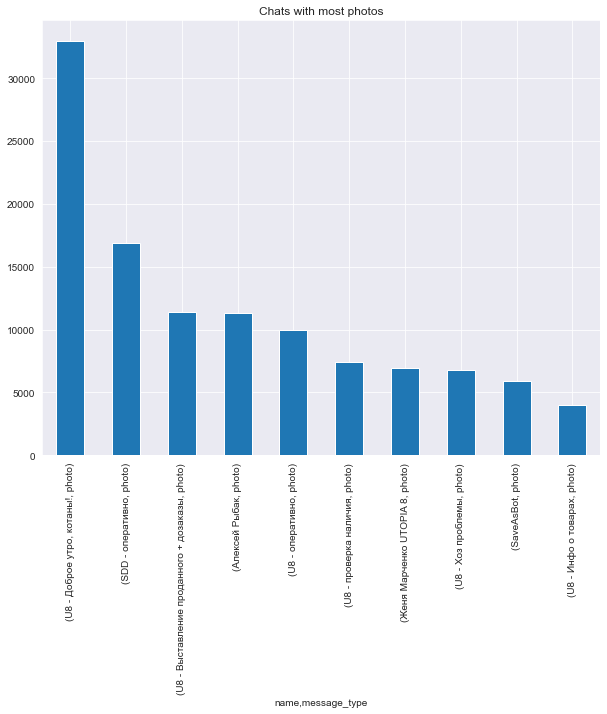

In [80]:
(df_full[['name','message_type']][df_full['message_type']=='photo']
 .value_counts()[:10]
 .plot
 .bar(title = "Chats with most photos", figsize=(10, 8)))

### What are the chats with most voice messages?

<AxesSubplot:title={'center':'Chats with most voices'}, xlabel='name,message_type'>

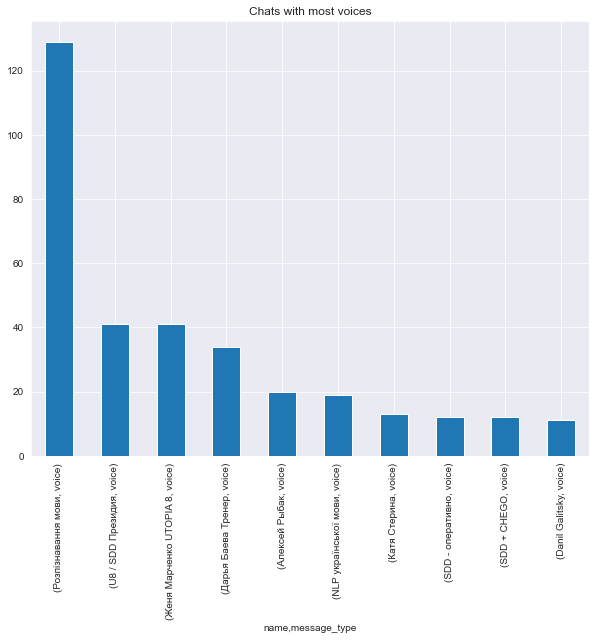

In [81]:
(df_full[['name','message_type']][df_full['message_type']=='voice']
 .value_counts()[:10]
 .plot
 .bar(title = "Chats with most voices", figsize=(10, 8)))

### What are the most popular websites that are referred to in general?

In [82]:
import re
from urllib.parse import urlparse

In [83]:
def find_urls(text):
    try:
        links =  re.findall(r'(https?://[^\s]+)', text)
        return [urlparse(item).netloc for item in links]
    except ValueError:
        return []

In [84]:
df_full['url_list'] = df_full['message'].apply(lambda x: find_urls(x))

<AxesSubplot:title={'center':'Most referenced websites'}>

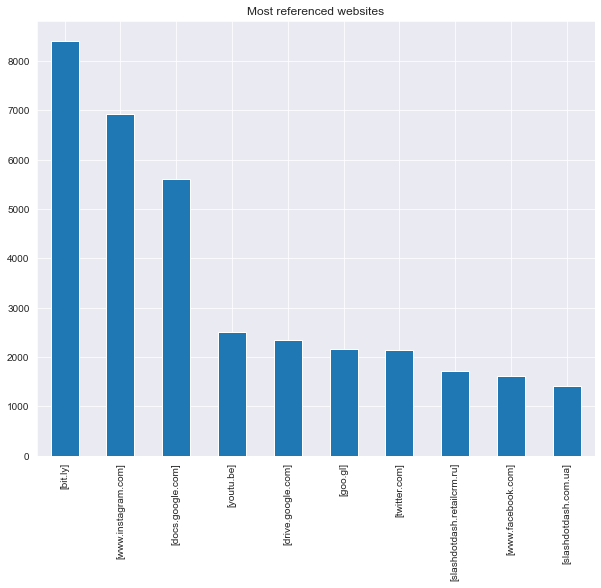

In [85]:
(df_full['url_list']
 .value_counts()[1:11]
 .plot
 .bar(title = "Most referenced websites", figsize=(10, 8)))

### What are the most popular websites that are referred to in non-work-related chats?


<AxesSubplot:title={'center':'Most referenced websites in non work chats'}>

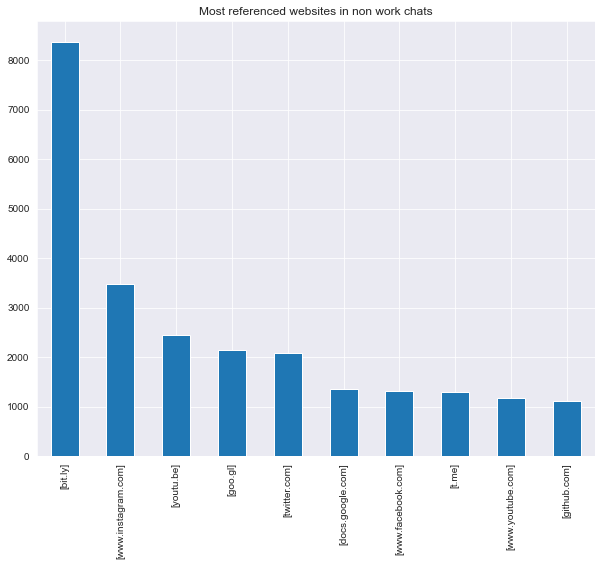

In [86]:
(df_full['message'][df_full['type_of_chat']=='play']
 .apply(lambda x: find_urls(x))
 .value_counts()[1:11]
 .plot
 .bar(title = "Most referenced websites in non work chats", figsize=(10, 8)))


### How do mentions of my nick handle (addressing me directly) change in work-related chats over time?

In [87]:
def check_if_mentioned(text):
    if '@BRVVA' in text.split(' '):
        return True
    else:
        return False

In [88]:
df_full['check_if_mentioned'] = df_full['message'].apply(lambda x: check_if_mentioned(x))

In [89]:
df_mentions = (df_full[['date', 'type_of_chat','check_if_mentioned']][(df_full['type_of_chat']=='work')&(df_full['check_if_mentioned']==True)&(df_full['dialog_type']=='Group')]
               .assign(date = lambda df_: pd.to_datetime(df_['date']))
               .set_index('date')
               .resample('M')
               .sum())


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_45947/3288004892.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


Text(0.5, 0.98, 'Change addressing me directly in work related chats')

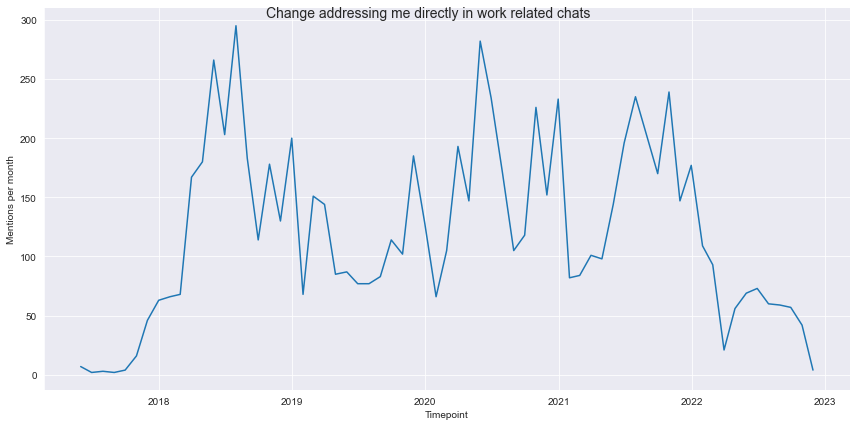

In [90]:
g = sns.relplot(
 kind='line',
 data=df_mentions,
 x='date', y='check_if_mentioned',
 palette = ['blue'],
 hue_order = ['mentions'],
 # hue='type_of_chat',
 height=6,
 aspect = 2
)
(g
    .set_axis_labels("Timepoint", "Mentions per month")
    .tight_layout(w_pad=0)
    .fig.suptitle("Change addressing me directly in work related chats", fontsize=14))

# Homework #6. Improve behaviour exploration

The main focus -- my personal communication patterns and in particular - shifts caused by major events (start of the UCU masters and full-scale invasion).
I've
- improved graphs (translated seaborn and matplotlib into plotnine, added vlines for illustrative purposes)
- improved text preprocessing
- grouped questions into meaningful blocks
- added a couple approaches to topic modeling as suggested in the task description
- added comments to explain illustrations

## How did patterns of my work / study engagement usage evolve?

In order to analyse my work and study involvement patterns we'll employ slightly different methods for both work and study since the signs of my involvement are different.

**The most indicative for my work chats are mentions of my nick handle** - since I'm the owner of several small businesses, I myself set the rules for my involvement in group chats: the general rule is to always use my nick handle when addressing me directly. Dynamics of such messages will demonstrate how "locked" are certain processes on my decisions.

**The most indicative for my study chats are the messages from me to others** since the communication is horizontal and in our main TG chat we don't usually address each other directly through the nick handles.

### I mark major event with vertical lines - red for war, green for start of masters, yellow for covid.

In [91]:
from plotnine import *

In [92]:
df_mentions = df_mentions.reset_index()

I mark start of active study and full scale invasion to see if trends are influenced by those milestones.

In [93]:
ucu_start = pd.Timestamp("2021-10-20 05:00") # I take my first homeworks as a start date
invasion = pd.Timestamp("2022-02-24 05:00")

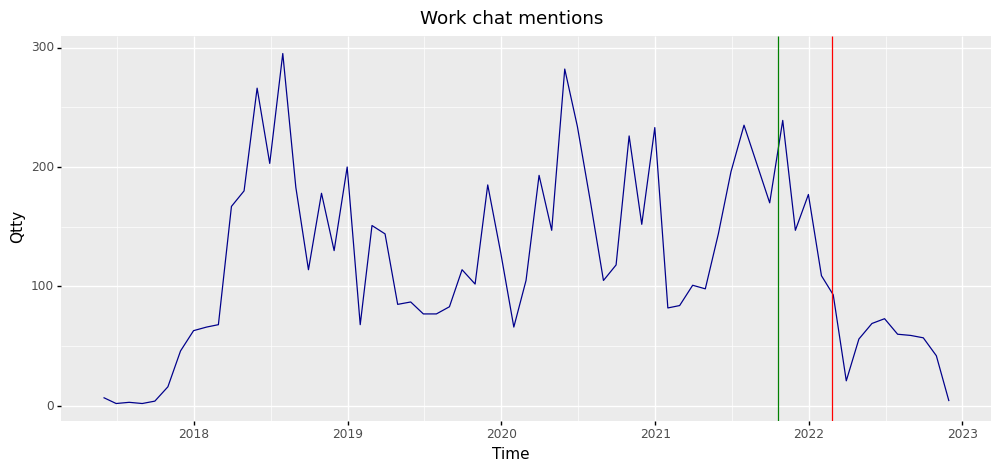

<ggplot: (954651320)>

In [94]:
from mizani.formatters import date_format

mentions_plot = ggplot(df_mentions) \
                + aes(x="date", y="check_if_mentioned") \
                + geom_line(color='darkblue') \
                + labs(title="Work chat mentions", y="Qtty", x="Time") \
                + geom_vline(xintercept = invasion, color = 'red') \
                + geom_vline(xintercept = ucu_start, color = 'green') \
                + scale_x_datetime(labels=date_format('%Y')) \
                + theme(figure_size=(12, 5))
mentions_plot

We observe that both events made the same effect - I've grown more and more detached (purposefully ofcourse) from management duties.

In [876]:
df_sent_study = df_full[(df_full['type_of_chat']=="study")&(df_full['recipient_type']=="sent")]

In [877]:
df_sent_study = (df_full[['date', 'message']][(df_full['type_of_chat']=="study")&(df_full['recipient_type']=="sent")]
                 .assign(date = lambda df_: pd.to_datetime(df_['date']))
                 .set_index('date')
                 .resample('1W')
                 .count()
                 .reset_index())

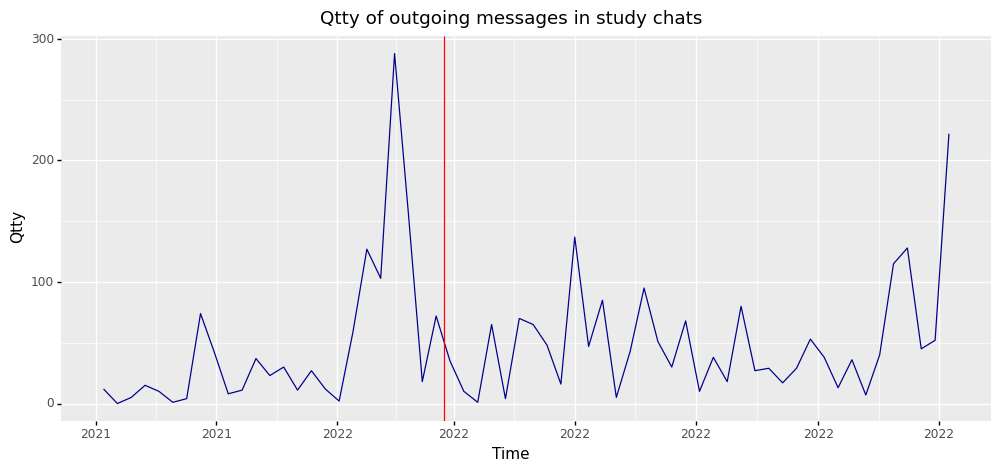

<ggplot: (1188407926)>

In [878]:
sent_study_plot = ggplot(df_sent_study) \
                + aes(x="date", y="message") \
                + geom_line(color='darkblue') \
                + labs(title="Qtty of outgoing messages in study chats", y="Qtty", x="Time") \
                + geom_vline(xintercept = invasion, color = 'red') \
                + scale_x_datetime(labels=date_format('%Y')) \
                + theme(figure_size=(12, 5))
sent_study_plot

But war had no effect on communication in study chats whatsoever - it was mostly affected by end of semester deadlines.

I'm using 3 type of chats here: work, study and leisure (aka play) to separate different types of communication goals.
As a proxy to the common measure of involvement for three types of chats I'm using average message length

In [98]:
def mark_type_chats(chat_name):
    study_indicators = ['ucu', 'proj', "project", 'paranoic', "уку"]
    work_indicators = ['u8', 'utopia8', "sdd", 'utopia', "slashdotdash", "slash dot dash", "utopia8.ua"]
    if len(set(str(chat_name).lower().split(' ')).intersection(set(work_indicators)))>0:
        return "work"
    elif len(set(str(chat_name).lower().split(' ')).intersection(set(study_indicators)))>0:
        return "study"
    else:
        return "play"

In [99]:
df_full['type_of_chat'] = df_full['name'].apply(lambda x: mark_type_chats(x))

In [100]:
df_length = (df_full[df_full['recipient_type']=='sent'][['length', 'type_of_chat', 'date']]
 .groupby(['date', 'type_of_chat'])['length']
 .mean()
 .to_frame()
 .reset_index()
 .assign(date = lambda df_: pd.to_datetime(df_['date']))
 .set_index('date'))

I'm smoothing lines a bit more (in 2 month intervals) to see more stable trends.

In [101]:
summary_length = (df_length[['length', 'type_of_chat']]
                  .groupby('type_of_chat')['length']
                  .resample('2M')
                  .mean()
                  .reset_index(name="average_length")
                  .fillna(0))

In [102]:
summary_length['type_of_chat'] = summary_length.type_of_chat.astype('category')


In [103]:
ucu_start = pd.Timestamp("2021-10-20 05:00") # I take my first homeworks as a start date
invasion = pd.Timestamp("2022-02-24 05:00")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


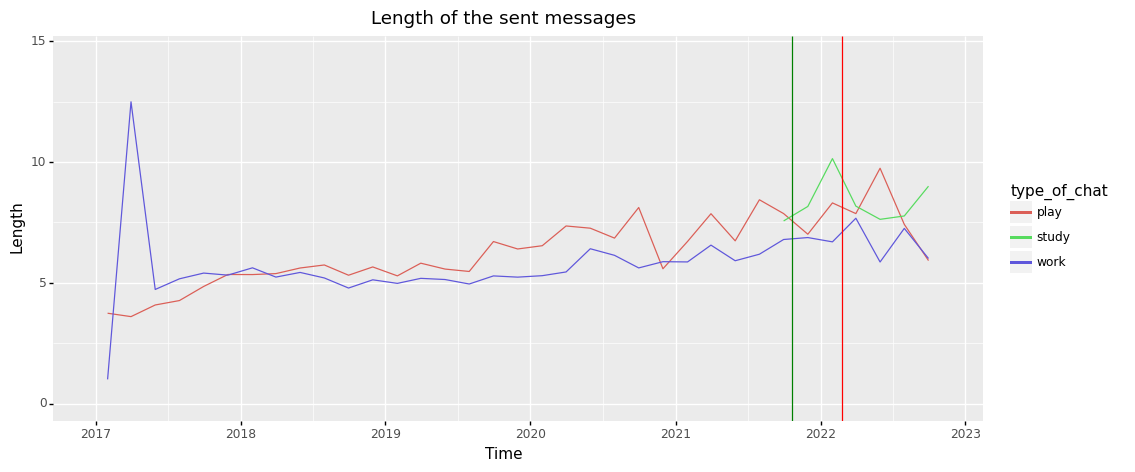

<ggplot: (954836474)>

In [104]:
length_plot = (ggplot(summary_length)
                + aes(x="date", y="average_length", color='type_of_chat')
                + geom_line()
                + labs(title="Length of the sent messages", y="Length", x="Time")
                + geom_vline(xintercept = invasion, color = 'red')
                + geom_vline(xintercept = ucu_start, color = 'green')
                + scale_x_datetime(labels=date_format('%Y'),
                                   limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
                + theme(figure_size=(12, 5)))
length_plot

## How did patterns of language usage evolve after the 24 February?

First obvious choice of measure - quantity of messags in main languages.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 20 rows containing missing values.


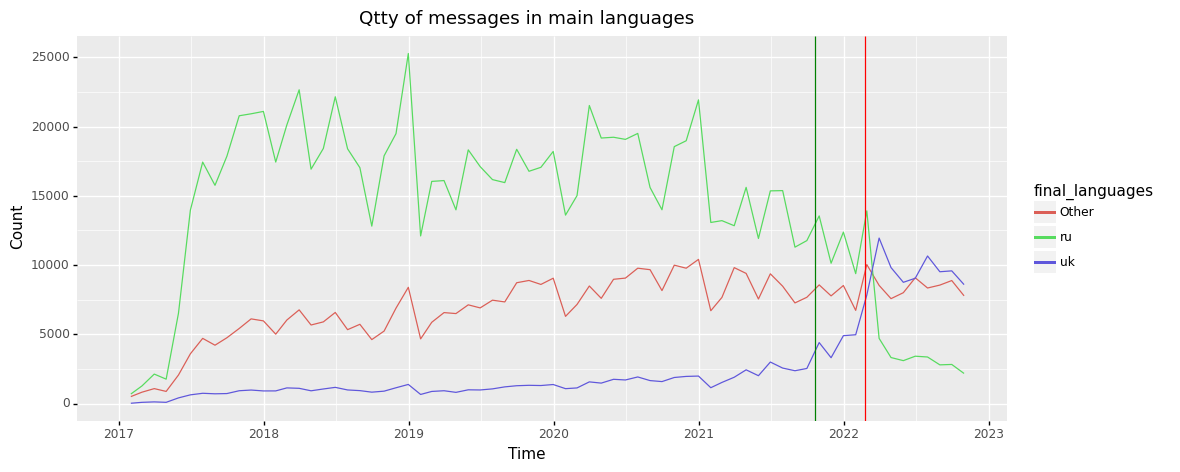

<ggplot: (730591485)>

In [105]:
from mizani.formatters import date_format

lang_plot_count = (ggplot(summary)
                + aes(x="date", y="count", color='final_languages')
                + geom_line()
                + labs(title="Qtty of messages in main languages", y="Count", x="Time")
                + geom_vline(xintercept = invasion, color = 'red')
                + geom_vline(xintercept = ucu_start, color = 'green')
                + scale_x_datetime(labels=date_format('%Y'),
                                   limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
                + theme(figure_size=(12, 5)))
lang_plot_count

Perhaps proportion will be more illustrative.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 20 rows containing missing values.


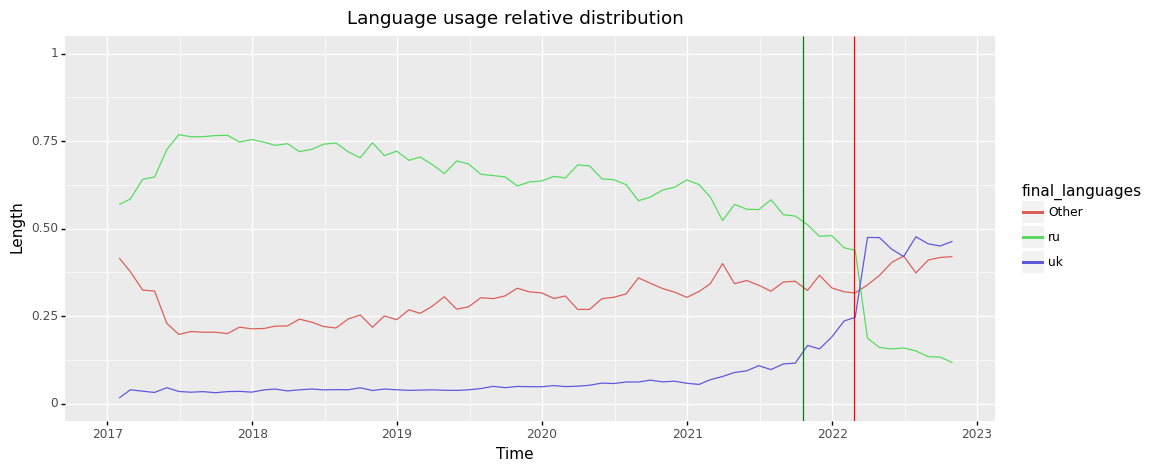

<ggplot: (730643709)>

In [106]:
lang_plot_count = (ggplot(summary2)
                + aes(x="date", y="percentage", color='final_languages')
                + geom_line()
                + labs(title="Language usage relative distribution", y="Length", x="Time")
                + geom_vline(xintercept = invasion, color = 'red')
                + geom_vline(xintercept = ucu_start, color = 'green')
                + scale_x_datetime(labels=date_format('%Y'),
                                   limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
                + theme(figure_size=(12, 5)))
lang_plot_count

As expected we're seeing dramatic shift to Ukrainian and small uptick for the "other" - that also makes sense as we'll see in topic modeling (international political news to blame).

## How did topics change over time?

## Some preprocessing

In [819]:
df_messages_for_agg = df_full[['date', 'message']][(df_full['recipient_type']=='sent')&(df_full['type_of_chat']=='play')]

In [820]:
df_messages_weekly = (df_messages_for_agg
                      .set_index('date')
                      .resample('W')
                      .agg(list)
                      .reset_index())

In [821]:
df_messages_weekly = df_messages_weekly[df_messages_weekly['message'].map(lambda d: len(d)) > 0]

In [823]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

In [824]:
df_messages_weekly['flat_texts'] = (df_messages_weekly['message']
                                     .apply(lambda x: remove_emoji(" ".join(x)))
                                     .str.replace('http\S+|www.\S+', '', case=False))

In [825]:
#extending to common cases
punctuation = punctuation +"???" +"!!!!!"+"))))))"+"(((((((("

In [826]:
import spacy

In [827]:
nlp = spacy.load("ru_core_news_sm")

In [828]:
all_stopwords = stop_words_ua + stop_words_ru

In [829]:
def tokenize_spacy(text):
    doc = nlp(text)
    result = [token.lemma_ for token in doc]
    return result

In [830]:
def lang_uk_tokenize(text):
    all_stopwords = stop_words_ua + stop_words_ru
    word_tokens = tokenize_words(text.lower())
    word_tokens = [token for token in word_tokens if token not in (punctuation or all_stopwords)]
    return word_tokens

In [834]:
%%time
df_messages_weekly['tokens'] = df_messages_weekly['flat_texts'].apply(lambda x: tokenize_spacy(x))

CPU times: user 4min 18s, sys: 3.38 s, total: 4min 21s
Wall time: 4min 22s


Getting rid of most common 200 words (I've tried various number and this one seems most appropriate)

In [835]:
top_words = (pd.DataFrame([item for sublist in df_messages_weekly.tokens.tolist() for item in sublist])
             .value_counts()[:220]
             .index
             .to_list())
stop_words = [item[0] for item in top_words]

In [836]:
stop_words.extend(['utopia_8', 'utopia8_kharkiv', 'utopia_8_od'])

In [837]:
%%time
df_messages_weekly['tokens'] = df_messages_weekly['tokens'].apply(lambda x: [item for item in x if item not in stop_words])

CPU times: user 1.18 s, sys: 413 ms, total: 1.6 s
Wall time: 1.68 s


Removing digits and short words

In [838]:
def remove_digits(text):
    result = re.sub(r'[0-9]+', '', text)
    return result


In [839]:
def remove_short(text_list):
    result = [word for word in text_list if len(word)>4]
    return result

In [840]:
df_messages_weekly['tokens'] = df_messages_weekly['tokens'].apply(lambda x: remove_short(x))

Setting date as index

In [842]:
df_messages_weekly = df_messages_weekly.set_index('date')

In [843]:
df_messages_weekly = df_messages_weekly.sort_index()

In [844]:
df_messages_weekly['clean_token_string'] = df_messages_weekly['tokens'].apply(lambda x: " ".join(x))
df_messages_weekly['clean_token_string'] = df_messages_weekly['clean_token_string'].apply(lambda x: remove_digits(x))

## With Bertopic

Lets try to use Bertopic for topic modeling. We'll group messages by type daily.

In [132]:
df_play_texts = df_messages_weekly[df_messages_weekly['type_of_chat']=='play']['clean_token_string']
play_text_list = df_play_texts.to_list()
play_dates = df_play_texts.reset_index().date.apply(lambda x: pd.Timestamp(x)).to_list()

In [135]:
from umap import UMAP

In [136]:
from bertopic import BERTopic

In [147]:
umap_model = UMAP(n_neighbors=15,
                       min_dist=0.0,
                       n_components=10,
                       metric='euclidean',
                       low_memory=False,
                       random_state=42)

In [148]:
topic_model = BERTopic(min_topic_size=70, n_gram_range=(1,3), verbose=True, language="Ukrainian",umap_model=umap_model)

In [149]:
topics, _ = topic_model.fit_transform(play_text_list)

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

2022-12-07 13:33:18,355 - BERTopic - Transformed documents to Embeddings
2022-12-07 13:33:23,976 - BERTopic - Reduced dimensionality
2022-12-07 13:33:24,071 - BERTopic - Clustered reduced embeddings


In [150]:
freq = topic_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,1353,-1_області_під_in_випадків
1,0,363,0_тебя_даже_буду_которые
2,1,300,1_під_області_in_також
3,2,246,2_випадків_коли_року_де
4,3,228,3_випадків_області_чтобы_де
5,4,184,4_которые_чем_потому_чтобы


Okay, that is ridiculously uninformative, lets try Word2Vec / TFIDF with KNN clustering.

## KNN


In [202]:
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

In [391]:
from gensim.models import KeyedVectors

model_path = "/Users/katerynaburovova/PycharmProjects/comp_soc_sci_projects/HW_6/ubercorpus.lowercased.tokenized.word2vec.300d"
word2vec = KeyedVectors.load_word2vec_format(model_path, binary = False)

In [392]:
wtv_vect = WordVecVectorizer(word2vec)

In [845]:
X_train_wtv = wtv_vect.transform(df_messages_weekly['clean_token_string'])

In [846]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
model = tfidf_vec.fit(df_messages_weekly['clean_token_string'])
X_train_tfidf = model.transform(df_messages_weekly['clean_token_string'])

In [847]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=12, init='k-means++',
    n_init=10, max_iter=2000,
    tol=1e-04, random_state=100
)
y_w2v_km = km.fit_predict(X_train_wtv)
y_tf_km = km.fit_predict(X_train_tfidf)

In [848]:
df_messages_weekly['clusters_w2v'] = y_w2v_km

In [849]:
df_messages_weekly['clusters_tfidf'] = y_tf_km

In [850]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words=stop_words).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

#from https://medium.com/analytics-vidhya/topic-modelling-using-word-embeddings-and-latent-dirichlet-allocation-3494778307bc

In [851]:
def plot_cluster(df, type, cluster_no, n_words):
    words = []
    word_values = []
    if type=="tfidf":
        for i,j in get_top_n_words(df['clean_token_string'][df['clusters_tfidf']==cluster_no],n_words):
            words.append(i)
            word_values.append(j)
    if type=="w2v":
        for i,j in get_top_n_words(df['clean_token_string'][df['clusters_w2v']==cluster_no],n_words):
            words.append(i)
            word_values.append(j)
    df_ = pd.DataFrame(list(zip(words, word_values)), columns =['words', 'counts'])
    title_ = f'Top {n_words} words for cluster {cluster_no}'
    plot_count = (ggplot(df_)
                + labs(title=title_, y="counts", x="words")
                + geom_col(aes(x='words', y='counts'), fill='blue')
                + coord_flip()
                + theme(figure_size=(5, 3)))
    return plot_count


I've pre-selected some meaningful plots to be able to track only meaningful ones. I've chosen TFIDF only since W2V results were not really illustrative. That makes sense - we've only been using uk model for the whole dataset, tfidf handles our case better since it's not language specific.


In [852]:
df_messages_weekly['topic_name'] = ''

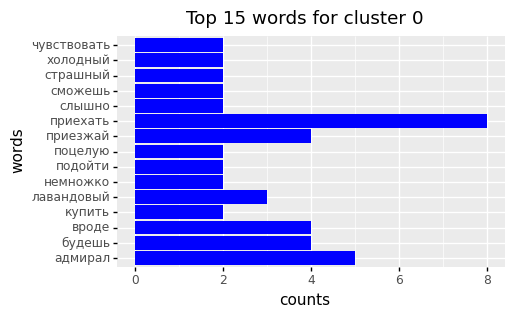

<ggplot: (1295100293)>

In [857]:
# emotional_alignment
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==1), 'emotional alignment')
plot_cluster(df_messages_weekly, 'tfidf', 0, 15)

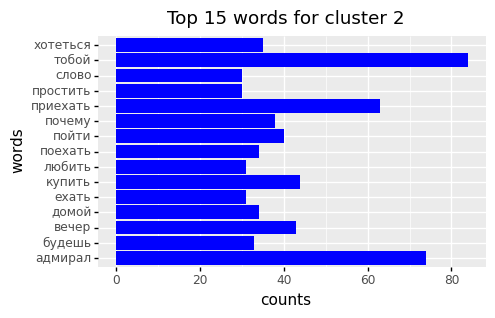

<ggplot: (991700321)>

In [858]:
# dating
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==2), 'dating before marriage')
plot_cluster(df_messages_weekly, 'tfidf', 2, 15)

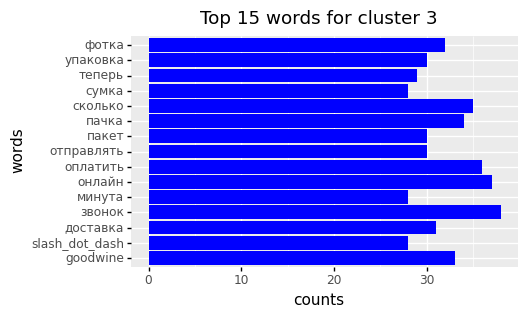

<ggplot: (1212573329)>

In [859]:
# shopping
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==3), 'covid shopping')
plot_cluster(df_messages_weekly, 'tfidf', 3, 15)

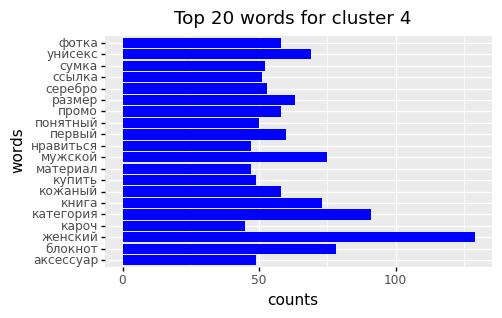

<ggplot: (1195821370)>

In [861]:
# helping_the_team
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==4), 'helping the team')
plot_cluster(df_messages_weekly, 'tfidf', 4, 20)

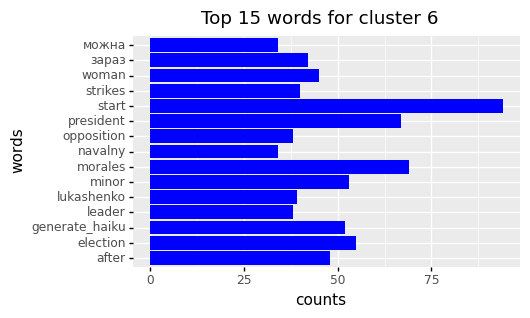

<ggplot: (1195428892)>

In [863]:
# political_news
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==6), 'political news')
plot_cluster(df_messages_weekly, 'tfidf', 6, 15)

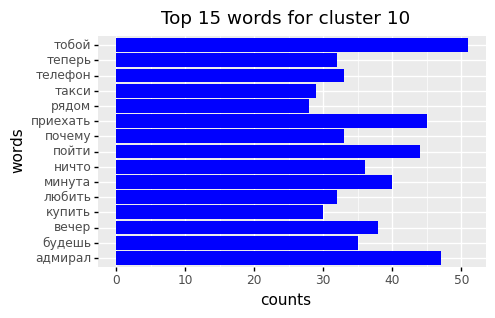

<ggplot: (1338760081)>

In [869]:
# political_news
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==10), 'dating before marriage')
plot_cluster(df_messages_weekly, 'tfidf', 10, 15)

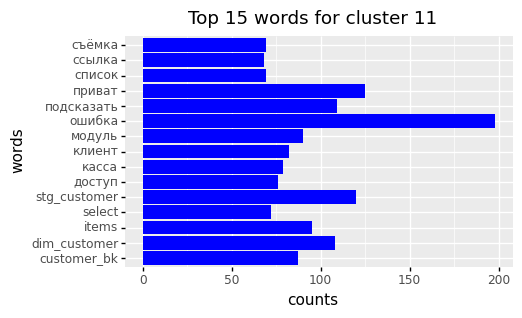

<ggplot: (734681480)>

In [865]:
# troubleshooting
df_messages_weekly['topic_name'] = df_messages_weekly['topic_name'].mask((df_messages_weekly['clusters_tfidf']==11), 'troubleshooting')
plot_cluster(df_messages_weekly, 'tfidf', 11, 15)

In [870]:
df_messages_final = df_messages_weekly[df_messages_weekly['topic_name']!=''].copy()

In [874]:
covid = pd.Timestamp("2020-03-11 00:00")

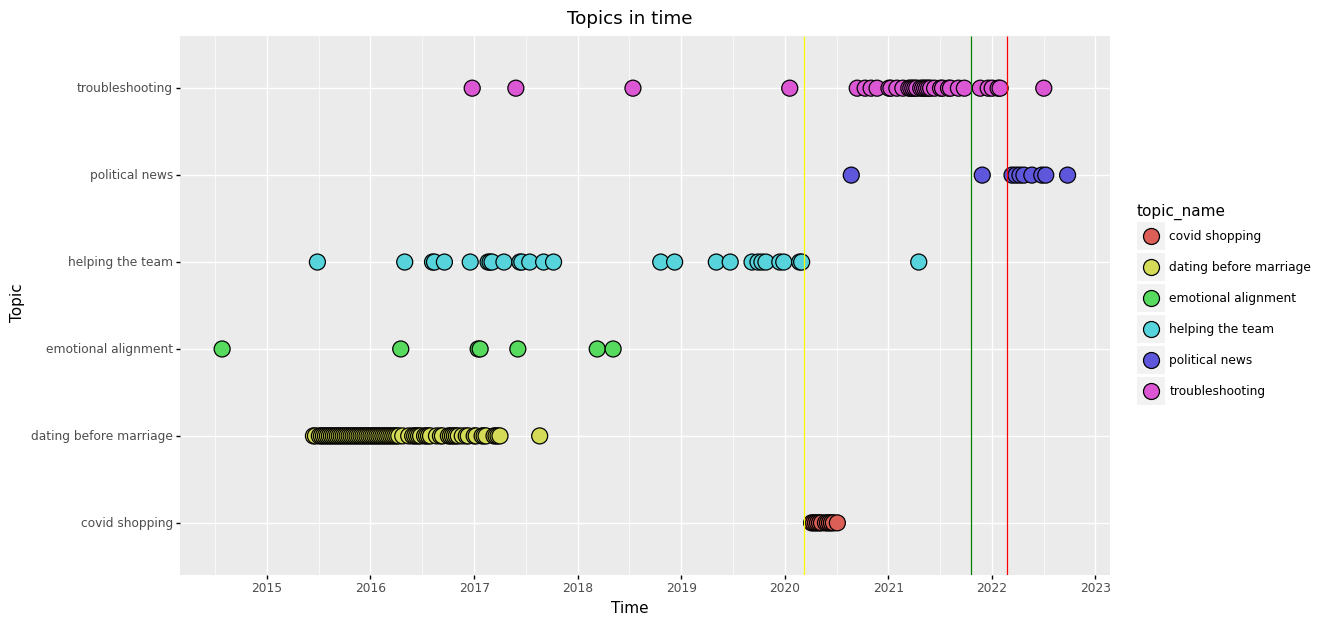

<ggplot: (936564797)>

In [875]:
topic_plot = ggplot(df_messages_final.reset_index()) \
                + aes(x="date", y='topic_name', fill="topic_name") \
                + geom_point(size=6) \
                + labs(title="Topics in time", y="Topic", x="Time") \
                + geom_vline(xintercept = invasion, color = 'red') \
                + geom_vline(xintercept = covid, color = 'yellow') \
                + geom_vline(xintercept = ucu_start, color = 'green') \
                + scale_x_datetime(labels=date_format('%Y')) \
                + theme(figure_size=(12, 7))
topic_plot

Topics are indeed interpretable - and dynamics is explainable.
I took only my messages (sent by me) in non-work and non-study chats (that we've categorised as "play") - everything else is a bit boring to have to deal with. Nevertheless, some work themes "leaked" into data, since there is almost no way to filter out every single personal dialog with my colleagues.

**dating before marriage** ends with marriage for all the right reasons - communication continued offline mostly

**helping the team** marks period of my peak micromanagement, covid made me rethink priorities. This trend actually follows trend in direct "mentions".

**troubleshooting** intensified with troubles - covid quarantines, implementation of fiscalisation, and obviously - war.

I've started to share more **political news** with the beginning of the ful scale invasion

**covid shopping** was a thing when I stopped leaving my flat even for groceries (but I overcame panic some time soon)






## How did emotional dynamics change over time?

In [141]:
### What are the 20 most popular emojis in general?
### What are my favourite emojis? !FOR HW6!
# + tonal dict

In [ ]:
df_emojis = (df_full['emoji_data']
             .sample(100000, random_state=42)
             .apply(pd.Series, dtype = 'object')
             .fillna(0)
             )

In [885]:
df_my_emojis = (df_full['emoji_data'][df_full['recipient_type']=='sent']
             .apply(pd.Series, dtype = 'object')
             .fillna(0)
             )

In [886]:
cols = df_my_emojis.T.columns
df_my_emojis = df_my_emojis.T.reset_index()
df_my_emojis['count'] = df_my_emojis.iloc[:, 1:-1].sum(axis=1)
df_my_emojis = df_my_emojis.drop(columns=cols)
df_my_emojis = df_my_emojis.set_index('index')

In [903]:
my_emoji_list  = (df_my_emojis
                  .sort_values(by='count', ascending=False)[:20]
                  .reset_index()
                  .rename(columns = {'index':'emoji'})
                  .emoji
                  .to_list())
my_emoji_list

['❤',
 '🙏',
 '👀',
 '☺',
 '🙌',
 '🙈',
 '💪',
 '🤓',
 '😘',
 '😏',
 '👍',
 '🙂',
 '👌',
 '😂',
 '🔥',
 '😁',
 '😎',
 '🤝',
 '😱',
 '🥰']

Above are my most used emojis ordered by descending count.

In [917]:
def add_col_with_count(df):
    for emoji in my_emoji_list:
        df[emoji] = df['emoji_data'].apply(lambda x: x[emoji])
    return df

In [914]:
df_full[my_emoji_list[0]] = ''
df_full[my_emoji_list[0]] = df_full['emoji_data'].apply(lambda x: x[my_emoji_list[0]])

In [923]:
df_emoji_dynamics = add_col_with_count(df_full[['date', 'emoji_data']][df_full['recipient_type']=='sent'])

In [924]:
df_emoji_dynamics = (df_emoji_dynamics
                     .set_index('date')
                     .resample("M")
                     .sum())

I've selected ones with most interesting insights.

❤


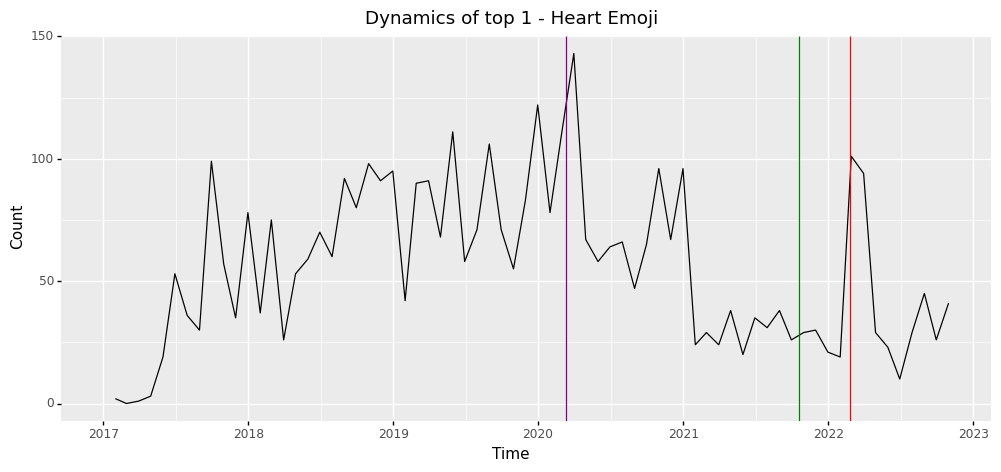

<ggplot: (1154515131)>

In [951]:
num=0
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title="Dynamics of top 1 - Heart Emoji", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

We see that the use of heart emoji gradually declined after covid pandemic started, but came back after the start of the full scale invasion - showing my love for the friends and family turned the tide.

🙏


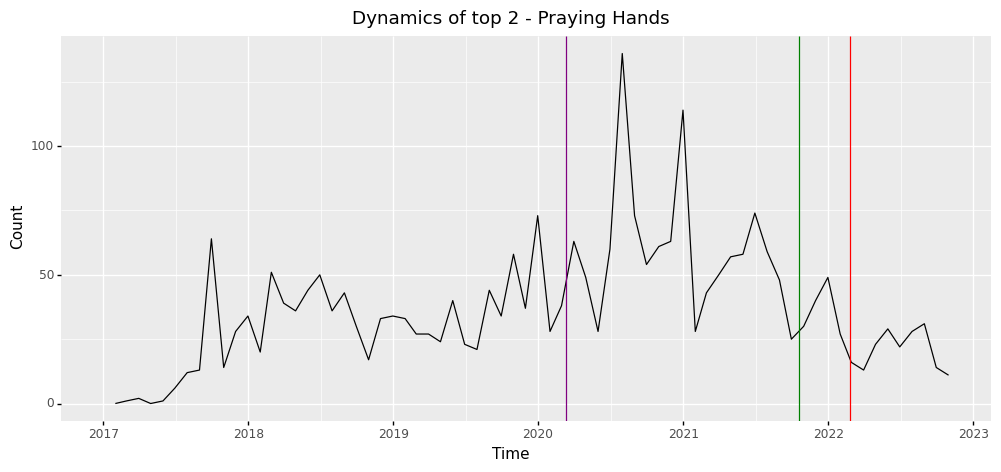

<ggplot: (911926733)>

In [954]:
num=1
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title=f"Dynamics of top {num+1} - Praying Hands", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

Praying hands emoji peaked in covid time - I guess that's for all my pleading for my parents to get the vaccine:)


☺


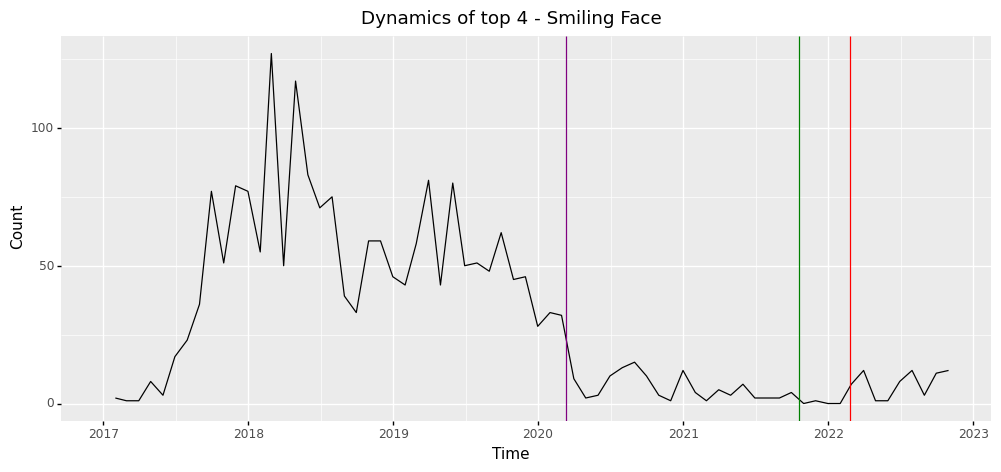

<ggplot: (1169393785)>

In [958]:
num=3
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title=f"Dynamics of top {num+1} - Smiling Face", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

The dynamics for smiling face is pretty self-explanatory (and sad).

👌


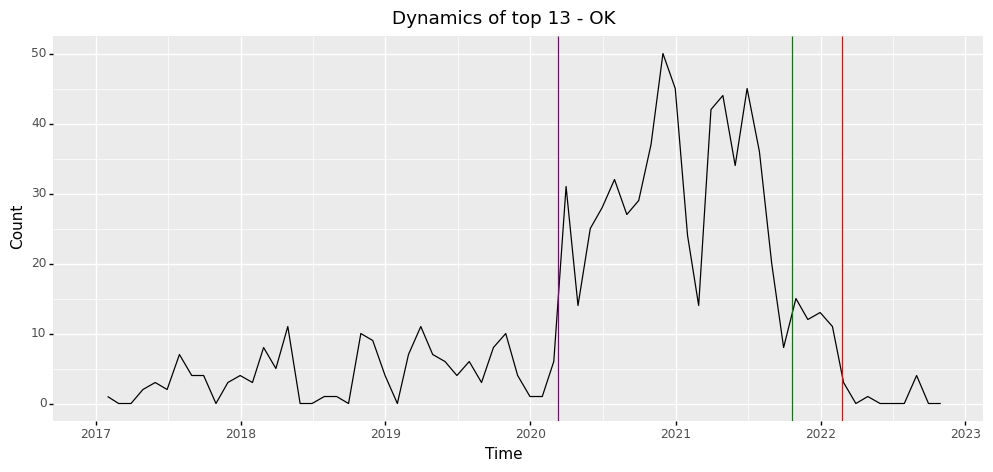

<ggplot: (991179243)>

In [1015]:
num=12
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title=f"Dynamics of top {num+1} - OK", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

I guess I switched to "OK" emotion after smiling face stopped being my thing.

🤝


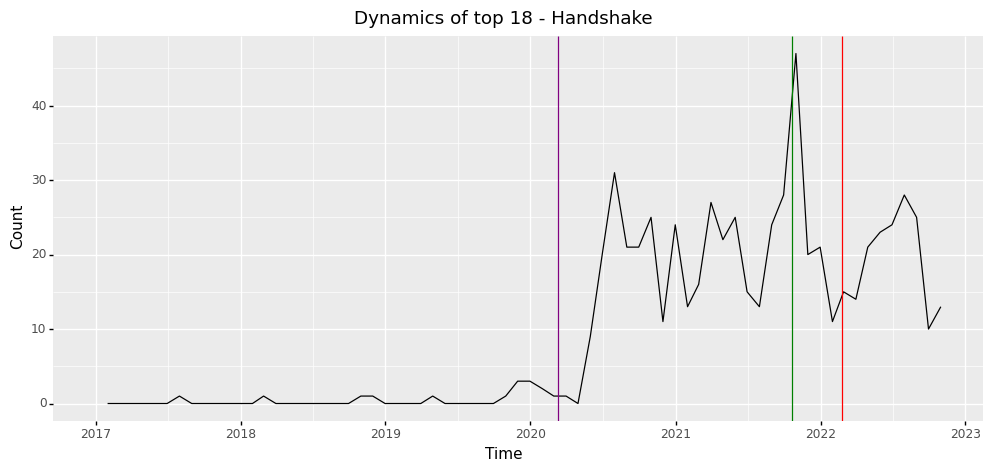

<ggplot: (911893833)>

In [1017]:
num=17
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title=f"Dynamics of top {num+1} - Handshake", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

😱


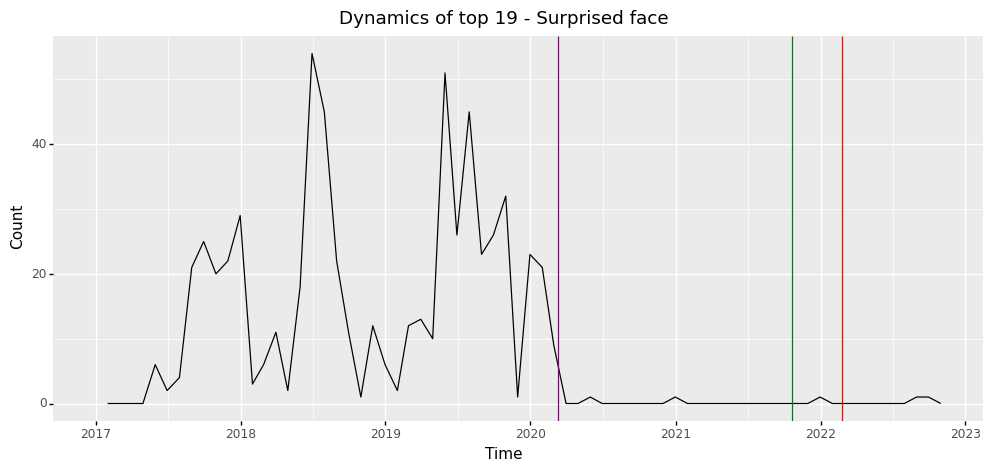

<ggplot: (951303268)>

In [1019]:
num=18
print(df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num])
plot_heart = (ggplot(df_emoji_dynamics.reset_index())
            + geom_line(aes(x="date", y=df_emoji_dynamics.reset_index().columns[1:-1].to_list()[num]))
            + labs(title=f"Dynamics of top {num+1} - Surprised face", y="Count", x="Time")
            + geom_vline(xintercept = invasion, color = 'red')
            + geom_vline(xintercept = covid, color = 'purple')
            + geom_vline(xintercept = ucu_start, color = 'green')
            + scale_x_datetime(labels=date_format('%Y'),
                               limits=[pd.Timestamp("2017-01-01 05:00"), pd.Timestamp("2022-11-01 00:00")])
            + theme(figure_size=(12, 5)))
plot_heart

Perhaps, after pandemic hit nothing surprises me anymore.